# How does unsupervised machine learning work?

In supervised machine learning tasks, the data is assigned to some set of classes. For example, here we are given a dataset wherein each observation is a set of physical attributes of an object. In an supervised task, the object column acts as the labels. The algorithm then uses these existing separations in the data to develop criteria for classifying unknown observations in the data. 

label | Height | Width | Color  | Mass | Round ?
-----  | -------| ------| -------| ---- | -------
Apple  | 6cm    | 7cm   | Red    | 330g | TRUE   
Orange | 6cm    | 7cm   | Orange | 330g | TRUE   
Lemon  | 5cm    | 4cm   | Yellow | 150g | FALSE  

In contrast, in an unsupervised machine learning task there either are no labels or that information is just treated as another attribute of the observation. In our fruit example, the object type is now just another characteristic of the observation, and often is altogether unknown:

object | Height | Width | Color  | Mass | Round ?
-----  | -------| ------| -------| ---- | -------
Apple  | 6cm    | 7cm   | Red    | 330g | TRUE   
Orange | 6cm    | 7cm   | Orange | 330g | TRUE   
Lemon  | 5cm    | 4cm   | Yellow | 150g | FALSE  
 
An unsupervised algorithm is not told how the data is structured or separated (barring parameter tuning); instead the algorithm goes looking for stucture and separation in the data. 

Clustering algorithms aim to group the observations in the data into categories (classes) based on some notion of how similar the observations are to each other. For example, given a basket of fruit, a clustering algorithm tries to group what it thinks are apples together into one class, and what it thinks are oranges into another. 

Dimension reduction techniques aim to decrease the number of rows and columns in a dataset based on some criteria such as which variables most separate the observations. For example, given the height, width, color, mass, and roundness of the fruit attributes, one dimension reduction algorithm will try to determine the minimum number of attributes needed to tell the fruit apart - can we tell it's an apple with just the mass and color? 

Generally speaking, in an unsupervised task there is no existing labeling to compare the results of the algorithm to; instead we often evaluate reliability through repeated experiments, computing the odds of our data being generated by our model, and visualizations. 

![algorithms_cheatsheet](../images/algorithms_cheatsheet.png)

### Read data in from NLTK book

In [1]:
import nltk
persuasion_raw = nltk.corpus.gutenberg.words('austen-persuasion.txt')
moby_raw = nltk.corpus.gutenberg.words('melville-moby_dick.txt')

In [2]:
persuasion_raw[:10]

['[', 'Persuasion', 'by', 'Jane', 'Austen', '1818', ']', 'Chapter', '1', 'Sir']

### Preparing data for machine learning
We're almost ready to do some machine learning!  First, we need to turn our texts into the type of *feature vectors* LDA expects to work with. To do this, we first need to break up our texts into smaller chunks for lda.

In [3]:
def chunk(doc, chunk_size=5000):
    """breaks up document into sections with chunk_size number of elements"""
    return [doc[i:i+chunk_size] for i in range(0, len(doc), chunk_size)]

persuasion_chunks = chunk(persuasion_raw)
moby_chunks = chunk(moby_raw)

In [4]:
print(len(persuasion_chunks))
print(len(moby_chunks))

20
53


The scikit learn feature extraction functions expect that the data is in a matrix or dataframe. Since we have an uneven number of words in the last chunk of each corpus, we can not bundle the data into an array. Instead we create a spreadsheet:

In [5]:
import pandas as pd
all_docs = pd.DataFrame({'words': persuasion_chunks + moby_chunks})
all_docs.head()

,words
0,"([, Persuasion, by, Jane, Austen, 1818, ], Cha..."
1,"(with, the, daughter, of, Mr, Shepherd, ,, who..."
2,"(ever, with, her, own, discretion, ,, never, w..."
3,"(,, without, much, waiting, for, an, answer, ;..."
4,"(father, ,, through, the, gloom, of, the, even..."


Then we untokenify our data and assign it to a new column called chunks

In [6]:
all_docs["chunks"] = all_docs['words'].str.join(" ")
all_docs['chunks'].head()

0    [ Persuasion by Jane Austen 1818 ] Chapter 1 S...
1    with the daughter of Mr Shepherd , who had ret...
2    ever with her own discretion , never wished th...
3    , without much waiting for an answer ; or in t...
4    father , through the gloom of the evening , to...
Name: chunks, dtype: object

#### Bag of Words
For LDA, we preprocess our data using sklearn's text feature extraction tools. In particular, we use the `CountVectorizer` which computes the frequency of each token in the document. We can strip out stop words using the `stop_words` keyword argument. A keyword argument is an optional function parameter. 

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

tf_vectorizer = CountVectorizer(stop_words='english')
tf = tf_vectorizer.fit_transform(all_docs['chunks'])

`CountVectorizer` processes the text such that `tf` is a sparse matrix containing the count of words in each document. A matrix is a table of numbers, and a sparse matrix is a table where most of those numbers are 0. `tf` is mostly 0 because many words only appear in a handful of the many documents that make up our sample corpus. Here is the start of one of the documents in our text:

> with the daughter of Mr Shepherd , who had returned , after an unprosperous marriage , to her father \' s house , with the additional burden of two children . She was a clever young woman , who understood the art of pleasing -- the art of pleasing , at least , at Kellynch Hall ; and who had made herself so acceptable to Miss Elliot , as to have been already staying there more than once , in spite of all that Lady Russell , who thought it a friendship quite out of place , could hint of caution and reserve .

Via the `CountVectorizer` the stop words, punctuation, and very low frequency words have been removed. The following is a sampling of some of the words and their counts:

```python
{'1806': 1, 'abroad': 2, 'acceptable': 1, 'accepted': 1, 'accidentally': 2, 'account': 1, 'acquaintance': 1,
 'acquainted': 3, 'acquired': 1, 'act': 1, 'acted': 1, 'action': 2,  'actions': 1, 'active': 1,
```

![Word cloud visualization, where the size of the word is relative to its frequency in the sentence described above](../images/countvect_wordcloud.png?)

## What is topic modeling using LDA?

![diagram showing a collection of texts then an arrow going towards a black box named LDA. On the other side of the black box are two arrows. One is slightly tilted up and points toward three circles. Each circle is a topic and contains a sample of words in that topic. The other arrow is slightly titled down and points towards a document. In the document, words are annotated to indicate which topic they belong to (if any)](../images/lda_diagram.png)

One subset of unsupervised learning tasks are topic extraction tasks, where the aim is to find common groupings of items across collections of items. One method of doing so is *Latent Dirichlet allocation (LDA)*. Latent Dirichlet Allocation is a way to model how topics are distributed over a corpus and words are distributed over a set of topics. 

In broad strokes, LDA extracts hidden (latent) topics via the following steps:<sup>1, 2</sup>

1. Arbitrariy decide that there are 10 topics
2. Select one document and randomly assign each word in the document to one of the 10 topics. 
3. Repeat 2 for all the other documents. This results in the same word being assigned to multiple topics.
4. Compute
    1. how many topics are in each document?
    2. how many topic assignements are due to a given word?
5. Take one word in one document and reassign it to a new topic and then repeat step 4.
6. Repeat step 5 until the model stabilizes such that reassign topics does not change distributions. 

LDA yields the a set of words associated to each topic (4.2) and the mixture of topics associated to each document (4.1).
    

<sup>1</sup>[Introduction to Latent Dirichlet Allocation](http://blog.echen.me/2011/08/22/introduction-to-latent-dirichlet-allocation/) by Edward Chen 

<sup>2</sup>[The LDA Buffet is Now Open](http://www.matthewjockers.net/2011/09/29/the-lda-buffet-is-now-open-or-latent-dirichlet-allocation-for-english-majors/) by Matthew Jockers 

<sup>3</sup> Image is inspired by Christine Doig's PyTexas 2015 ["Introduction to Topic Modeling"](http://chdoig.github.io/pytexas2015-topic-modeling/#/) presentation

## Let's do topic modeling with sklearn!
One of the best things about sklearn is the simplicity of its syntax.

To do machine learning with sklearn, follow these five steps (the function names remain the same, regardless of the algorithm you use!):

### Step 1:  Import your desired algorithm
In this example, we will be using the [Latent Dirichlet Allocation](http://scikit-learn.org/stable/modules/decomposition.html#latentdirichletallocation) algorithm. 

In [8]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

*RG Note: added numpy import here.  is needed for "np.set_printoptions(suppress=True)" below.

### Step 2: Create an instance of your machine learning algorithm
 When creating an instance of sklearn's `LatentDirichletAllocation` algorithm to run on our data, we need to set paramters. `n_components` is the number of topics in the dataset and we set `random_state` to 42 so that this notebook is reproducible. Since the sentences happen to already have labels (either news or romance), lets see if LDA can also find those seperations by setting the number of topics to 2. 

In [9]:
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42, max_iter=100)

### Step 3:  Fit your data
Using the `lda` object we set up above, we now apply (fit) the LDA algorithm to the bag of words we extracted from our sentences and had stored in the `tf` sparse matrix.

In [10]:
lda.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=100, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=42, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

### Step 4: Transform your data
We now want to model the documents in our corpus in terms of the topics discovered by the model. This is done using the `.transform` method of lda. This function yields the distribution of topics across the documents. The `document_topic` array contains the percentages of each topic found in each document. 

In [11]:
document_topic = lda.transform(tf)

Most of the 40 topics barely ever show up and are really noise, so we're gonna look at the maximum percentage of any topic 

In [14]:
#import numpy as np --RG added above to fix error
#print in regular notation
np.set_printoptions(suppress=True)
document_topic.max(axis=0)

array([0.99952772, 0.24388019, 0.99954191, 0.99953601, 0.0002994 ,
       0.99953674, 0.99953215, 0.99947115, 0.99951158, 0.99955372])

Out of all our topics, only a few show up in any significant amount anywhere. Let's get the indexes (identites) of those topics:

In [15]:
threshold = .1
# tells me if the condition is true
(document_topic.max(axis=0) > threshold)

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True])

In [16]:
# tells me where the condition is true
(document_topic.max(axis=0) > threshold).nonzero()

(array([0, 1, 2, 3, 5, 6, 7, 8, 9], dtype=int64),)

In [17]:
topic_inds = (document_topic.max(axis=0) > threshold).nonzero()[0]
num_top_topics = topic_inds.shape[0]
print(num_top_topics)


9


We can then use topic_inds to select into document_topic to get only the percentages of the top 4 topics. The format is `document_topic[row selection, column selection]`, where our documents are rows and the topics are columns.

In [18]:
document_topic[:, topic_inds].shape

(73, 9)

Then we visualize how much of each document is each topic - for example that document 1 is 10% topic A and 25% topic b. We choose an area chart because each band of the chart maps to a different category (in this case a unique topic). The width of each band in relation to the others illustrates how much of the document is thought to be about that topic relative to the others. We transpose `document_topic` using `.T` because we want the documents to be along the x axis here. Everything to the left of the black line is Persuasion, everything to the right is Moby Dick. 

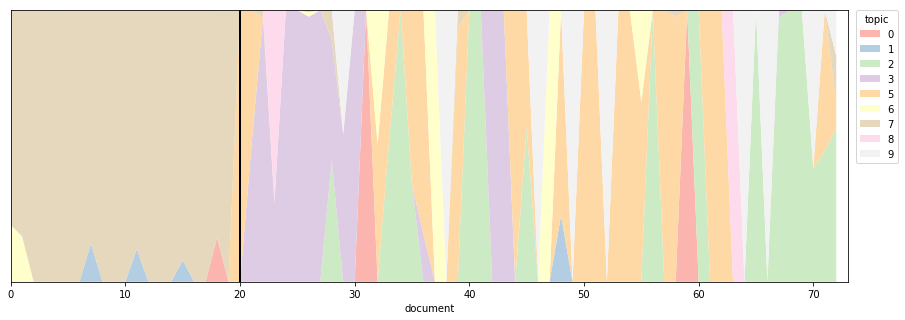

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as mcm
#import numpy as np #RG -- no longer needed

colors = [mcm.Pastel1(i) for i in range(num_top_topics)]
num_docs = document_topic.shape[0]

fig, ax = plt.subplots(figsize=(15,5))
_ = ax.stackplot(range(num_docs), document_topic[:, topic_inds].T, labels=topic_inds, colors=colors) #problem with 'labels=topics'
_ = ax.set_xlim(0, num_docs)
_ = ax.set_ylim(0,1)
_ = ax.set_yticks([])
_ = ax.set_xlabel("document")
_ = ax.axvline(len(persuasion_chunks), color='k', linewidth=2)
_ = ax.legend(title="topic", bbox_to_anchor=(1.06, 1), borderaxespad=0)
fig.savefig("../images/doc_topic.png", bbox_inches = 'tight', pad_inches = 0)

*RG -- not sure how to deal with this error.  unclear where "topics" as a label category would come from.  Nevermind, I figured it out from the code below

### Step 5: Print topics
`lda.components_` is an array where each row is a topic, and each column roughly conatins the number of times that word was assigned to that topic, which is also the probability of that word being in that topic. Here we also filter lda.components down to just our top topic rows. To figure out which word is which column, we use the `get_feature_names())` function from `CountVectorizer`. The `argsort` function is used to return the indexes of the columns with the highest probabilities, which we then map into our collection of words. Here we print the top 5 words in each topic.

In [20]:
num_words = 10
topic_word  = lda.components_[topic_inds]
words = np.array(tf_vectorizer.get_feature_names())
for i, topic in enumerate(topic_word):
    # sorting is in descending, so ::-1 reverses to ascending
    sorted_idx = topic.argsort()[::-1]
    print(i, words[sorted_idx][:num_words])

0 ['old' 'like' 'man' 'look' 'ahab' 'ship' 'great' 'whale' 'sun' 'round']
1 ['skin' 'blubber' 'breeze' 'stranger' 'sharks' 'laura' 'proved' 'marks'
 'rocks' 'jeroboam']
2 ['ahab' 'whale' 'like' 'boat' 'man' 'sea' 'ye' 'ship' 'thou' 'old']
3 ['ye' 'captain' 'ship' 'queequeg' 'like' 'said' 'man' 'old' 'sea' 'little']
4 ['whale' 'like' 'whales' 'sperm' 'ship' 'sea' 'head' 'great' 'man' 'old']
5 ['whale' 'white' 'old' 'cook' 'stubb' 'man' 'ahab' 'like' 'time' 'said']
6 ['anne' 'captain' 'mrs' 'elliot' 'mr' 'wentworth' 'lady' 'good' 'little'
 'said']
7 ['queequeg' 'sir' 'like' 'little' 'man' 'thou' 'leg' 'ye' 'ahab' 'coffin']
8 ['whale' 'ahab' 'like' 'man' 'boat' 'ye' 'ship' 'thou' 'old' 'stubb']


We can also visualize these topics as lists sized by the frequency of the word and colored by the topic, as proposed by Allan Riddell in [Text Analysis with Topic Models for the Humanities and Social Sciences](https://de.dariah.eu/tatom/index.html):

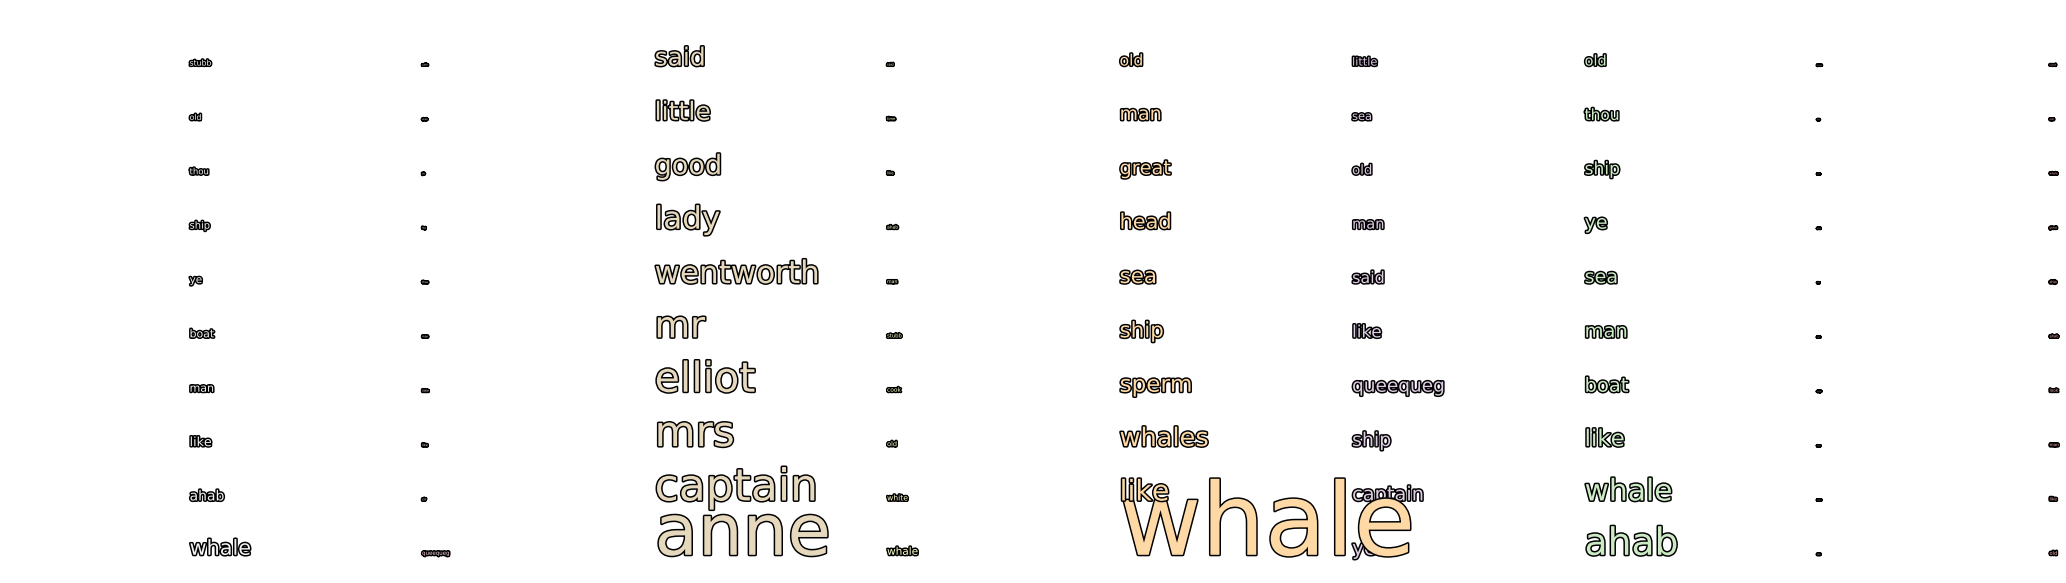

In [26]:
import matplotlib.patheffects as path_effects
# font size for word with largest share in corpus
fontsize_base = 100/ np.max(topic_word)

fig, ax = plt.subplots(figsize=(10,10), constrained_layout=True)

for i, topic in enumerate(topic_word):
    top_idx = topic.argsort()[::-1][:num_words]
    top_words = words[top_idx]
    top_share = topic[top_idx]
    for j, (word, share) in enumerate(zip(top_words, top_share)):
        text = ax.text(num_top_topics-i-0.5, j, word, fontsize=fontsize_base*share, color=colors[i])
        text.set_path_effects([path_effects.Stroke(linewidth=3, foreground='black'),
                       path_effects.Normal()])
        
#stretch the-axis to accommodate the words
ax.set_ylim(0, num_words)
ax.set_xlim(-.2, i/4+.2)
ax.axis('off')
#fig.subplots_adjust(hspace=-0)
fig.savefig("../images/word_topic.png", bbox_inches = 'tight', pad_inches = 0)
        

### Step 6: Score!
One method of evaluating a model is to compute the chance (probability) of the data we observed showing up in a dataset generated by the model. First we start with the modeled probability density function, which is the theoretical distribution of all topics in our model. We then use the *log likelihood* and the *perplexity* to evaluate the average odds of our observations occuring in the modeled distribution of words and topics. 

![the first is a plot of a normal (gaussian) curve, while the second is a plot of the log likelihood of the curve, and the third plot shows the perplexity of a distribution](../images/xkcd_False.png?)

Evaluate the success rate of the model by computing the 
* score: approximate log-liklihood - the higher the better
* perplexity: exponent of the negative log likelihood - the lower the better




In [27]:
print(f'Approximate Log Likelihood: {lda.score(tf)}')
print(f'Perplexity: {lda.perplexity(tf)}')

Approximate Log Likelihood: -1125700.2001819508
Perplexity: 5890.337263311171
